In [3]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

## 1. Python으로 단어 빈도를 세어 보기
우선 map-reduce를 사용하지 않고 단어의 갯수를 세어본다. 문서의 단어를 세는 알고리즘은 다음과 같다. 단어별 갯수를 저장하기 위해서는 **dictionary**를 사용한다.

#### 불용어 라이브러리
- 라이브러리에서 제공하는 불용어
Python nltk 라이브러리에서 제공하는 불용어를 사용하거나
```py
from nltk.corpus import stopwords
englishStops = set(stopwords.words('english'))
```

또는 skleran 라이브러리를 활용해도 된다.
```py
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
'the' in ENGLISH_STOP_WORDS # true
```

- 한글 불용어
한글 불용어는 불행히도 아직 제공되고 있지 못하여, 우리 스스로 임의로 만들어 쓰도록 하자. 본문을 읽어서 단어빈도를 세어도 별 의미가 없을만한 단어를 불용어에 넣어두자.

In [4]:
#set: 모두가 키, 중복 허용하지 않음
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

In [5]:
print(stopwords)

{'또는', '이', '등', '이와', '이런', '전', '그와', '간', '이를', '및', '두'}


In [6]:
'및' in stopwords

True

In [7]:
'한' in stopwords

False

불용어를 제거하고 출력해보자. 텍스트에는 아직 제거해야할 단어들이 다수 포함되어 있다. 컴마와 같은 기호, 숫자 등도 제거할 필요가 있다.

In [8]:
import os

#f=open(os.path.join("data", "ds_bigdata_wiki.txt"))
f=open(os.path.join("data", "ds_bigdata_wiki.txt"), 'rt', encoding='utf8')

#단어: 키, 단어빈도: value
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
d = dict()
for sent in f.readlines():
    _words = sent.split()  # split into words
    for word in _words:
        if word not in stopwords: # remove stopwords
            print(word, end='/')

Big/data/활용사례/의의[편집]/정치/사회[편집]/2008년/미국/대통령/선거[편집]/2008년/미국/대통령/선거에서/버락/오바마/미국/대통령/후보는/다양한/형태의/유권자/데이터베이스를/확보하여/분석,/활용한/'유권자/맞춤형/선거/전략'을/전개했다./당시/오바마/캠프는/인종,/종교,/나이,/가구형태,/소비수준과/같은/기본/인적/사항으로/유권자를/분류하는/것을/넘어서서/과거/투표/여부,/구독하는/잡지,/마시는/음료/유권자/성향까지/전화나/개별/방문을/소셜/미디어를/통해/유권자/정보를/수집하였다./수집된/데이터는/오바마/캠프/본부로/전송되어/유권자/데이터베이스를/온라인으로/통합관리하는/‘보트빌더(VoteBuilder.com)’시스템의/도움으로/유권자/성향/분석,/미결정/유권자/선별/,/유권자에/대한/예측을/해나갔다./바탕으로‘유권자/지도’를/작성한/뒤/‘유권자/맞춤형/선거/전략’을/전개하는/오바마/캠프는/비용/대비/효과적인/선거를/치를/수/있었다./대한민국/제19대/총선[편집]/중앙선거관리위원회는/대한민국/제19대/총선부터/소셜/네트워크/인터넷/상의/선거/운동을/상시/허용하였다.[15]/이에/소셜/미디어/상에서/선거/관련/데이터는/증폭되었으며,/2010년/대한민국/제5회/지방/선거/2011년/대한민국/재보궐선거에서/소셜/네트워크/서비스의/중요성을/확인한/정당들/또한/SNS/역량/지수를/공천/심사에/반영하는/등[16]/소셜/네트워크/활용에/주목했다./가운데/여론/조사/기관들은/기존/여론조사/방식으로/예측한/2010년/제5회/지방/선거/2011년/재보궐선거의/여론조사/결과와/실제/투표/결과와의/큰/차이를/보완하고자/빅/데이터/기술을/활용한/SNS/여론/분석을/시행했다./그러나/SNS/이용자의/대다수가/수도권/20~30대에/쏠려/있기에[17],/빅/데이터를/이용한/대한민국/제19대/총선에/대한/SNS/분석은/수도권으로/한정되어/일치하는/한계를/드러내기도/하였다./경제/경영[편집]/아마존닷컴의/추천/상품/표시///구글/페이스북의/맞춤형/광고[편집]/아마존닷컴은/모든

#### 단어빈도
불용어를 제거하는 기능을 확인했으니, 이제 print문 자리에 단어빈도를 계산하는 로직을 넣어주자.

In [10]:
import os

#f=open(os.path.join("data", "ds_bigdata_wiki.txt")) #cp949에러
f=open(os.path.join("data", "ds_bigdata_wiki.txt"), 'rt', encoding='utf8')

stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
d = dict()
for sent in f.readlines():
    _words = sent.split()  # split into words
    for word in _words:
        if word not in stopwords: # remove stopwords
            if word not in d: # 처음 만나면
                d[word]=1
            else:
                d[word]=d[word]+1

#### 정렬
단어빈도는 Python dictionary로 저장되어 있다. 이를 정렬하여 다시 dictionary로 저장하자.

dictionary는 key-value 쌍으로 구성되어 있다. 저장된 데이터는 반복문을 사용하여:

- `d.items()`으로 하나씩 key, value를 읽고
- `key=lambda x`:x[1]은 값을 키로해서,
- `reverse=True`는 내림차순으로 읽는다.

In [11]:
# {}: 딕셔너리, 딕셔너리로 만들어서 dSorted로
# key=lambda x: x[1] 키를 value로 잡고, 이로 정렬할 예정
dSorted = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}

지금은 전처리를 하지 않고 처리하고 있다. 교착어인 한국어의 특성을 감안해서 품사처리를 해야할 필요가 있다. 이음동의도 어떻게 분류할 것인지 감안해야 한다. 전처리를 하지 않은 문제점을 몇 가지 나열하자면:

- '빅데이터'와 '빅', '데이터' 다른 단어로 인식한다. 물론 첫 줄에 영어로 씌인 'Big data'를 인식하지 못하는 것은 물론이다.
- '대한'의 의미가 모호하다. '대한민국'인지, '~에 대한'의 의미인지 불분명하다.
- 다수의 한 글자 단어가 계산되었지만 의미가 모호하다.
    - '등'이 사람 신체의 부분을 말하는 것인지 '~하는 등'인지 불분명하다.
    - '수'란 단어 역시 '개수'를 의미하는 것인지 '~할 수'에 쓰이는 단어인지 불분명하다.
- 일정 빈도 이상을 선택하여 출력

In [32]:
d1 = dict()
for key, value in dSorted.items():
    if value>5:
        d1[key]=value
        print (f"{key}\t{value}")

데이터	21
데이터를	18
빅	14
있다.	9
수	8
데이터의	8
미국	7
통해	7
유권자	6
선거	6
대한	6
빅데이터	6


---
## 2. Pyspark로 단어빈도를 세어보기
- RDD 생성  
파일로부터 testFile()함수를 이용해 RDD를 생성한다.

In [14]:
myRdd3=spark.sparkContext\
    .textFile(os.path.join("data","ds_bigdata_wiki.txt"))

In [15]:
for i in myRdd3.take(2):
    print (i)

Big data
활용사례 및 의의[편집]


### flatMap vs map
- flatMap()은 리스트안에 또 리스트가 있는 경우 이를 하나의 **리스트**로 만든다.
- 반면에 map()은 리스트 안에 또 리스트가 있는 구조를 보존하고 처리한다.
- 다음에서 보듯이 flatMap()은 모든 단어를 하나의 리스트로 만들고 있다. 그러나 map() 파일의 줄마다 리스트를 만든다.


줄|원본|flatMap() 하고 나면|map() 하고 나면
:---|:---|:---|:---
1|Big data|좌동|[ 'Big', 'data' ]
2|활용사례 및 의의[편집]|좌동|[ '활용사례', '및', '의의[편집]' ]


In [16]:
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .take(10)

In [17]:
for i in wc3:
    print (i, end='/')

Big/data/활용사례/및/의의[편집]/정치/및/사회[편집]/2008년/미국/

리스트를 출력해보자. 반복문으로 리스트를 출력해도 2차원이라서 리스트를 완전하게 해체하지 못했다. 데이터를 출력하려면 리스트 당 1개의 반복문이 필요하다.

In [18]:
wc3=myRdd3\
    .map(lambda x:x.split())\
    .take(3)

In [19]:
for i in wc3:
    print (i, end='/')

['Big', 'data']/['활용사례', '및', '의의[편집]']/['정치', '및', '사회[편집]']/

**리스트 안에 또 리스트가 있는 구조**이므로, for문을 중첩하여 출력하자. print() 문은 한글을 그대로 유니코드로 출력한다.

In [20]:
for i in wc3:
    for j in i:
        print (j, end='/')

Big/data/활용사례/및/의의[편집]/정치/및/사회[편집]/

### stopwords 제거
불용어를 처리해 보자. 한글은 유니코드로 영어는 소문자로 변환한 후 불용어는 제거한다.

In [21]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
wc3_stop1 = myRdd3\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .take(10)

In [22]:
for i in wc3_stop1:
    print (i, end='/')

Big/data/활용사례/의의[편집]/정치/사회[편집]/2008년/미국/대통령/선거[편집]/

### 단어 빈도
당연하겠지만, 우선 각 단어마다 빈도1의 값을 주게 된다. 다음에서 보듯이, (단어,1)로 만들게 된다.  
flatMap()을 하지 않고, 단순하게 map()을 하여 갯수를 세면 문장으로 세어진다.  

- map을 하면 split 되지 않는다. 
- 2번째 라인은 유니코드? (원래 한글임... 활용사례 및 의의 )


줄|map()을 한 경우|flatMap()을 한 경우
:---|:---|:---
1|(u'Big data', 1)|(u'Big', 1) (u'data', 1)
2|(u'\ud65c\uc6a9\uc0ac\ub840 \ubc0f \uc758\uc758[\ud3b8\uc9d1]', 1)|(u'\ud65c\uc6a9\uc0ac\ub840', 1) (u'\ubc0f', 1) (u'\uc758\uc758[\ud3b8\uc9d1]', 1)

In [23]:
wc3=myRdd3\
    .map(lambda x:(x,1))\
    .take(3)
for i in wc3:
    print (i, end='/')

('Big data', 1)/('활용사례 및 의의[편집]', 1)/('정치 및 사회[편집]', 1)/

In [24]:
wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .take(10)
for i in wc3:
    print (i, end='/')

('Big', 1)/('data', 1)/('활용사례', 1)/('및', 1)/('의의[편집]', 1)/('정치', 1)/('및', 1)/('사회[편집]', 1)/('2008년', 1)/('미국', 1)/

### 묶어서
줄|설명
:---|:---
flatMap|파일 전체를 (flat해서) map. flat하지 않으면 줄바꿈으로 구분함.
fliter|불용어 목록에 있으면 제거함.
map|단어별로 (x,1)로 구성함
reduceByKey|동일한 단어(키)의 value, 즉 갯수를 서로 합하게 됨.
map()|앞 함수의 출력 (x,1)의 순서를 바꿈. 즉, 갯수x[1]를 앞으로 단어x[1]을 뒤로 자리 바꿈.
sortByKey(false)|내림차순 정렬 (오름차순이 default), 빈도가 키가 되었으므로 빈도로 정렬됨
take(10)|10개를 선택함.

In [25]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(15)

In [26]:
print (type(wc3))
for i in wc3:
    print (i[0],i[1])

<class 'list'>
21 데이터
18 데이터를
14 빅
9 있다.
8 수
8 데이터의
7 미국
7 통해
6 유권자
6 선거
6 대한
6 빅데이터
5 활용한
5 소셜
5 대한민국


### 단어빈도로 가로막대그래프 그리기
데이터는 다음과 같이 [빈도, 단어]로 구성되어 있다.

[ 21, '데이터' ]
...
x축은 barh()로 개수를 나타내고 y축은 단어를 나타낸다.

In [28]:
k=list()
v=list()
for i in wc3:
    v.append(i[0])
    k.append(i[1])

가로막대그래프 y축 위치는 range(len(v)) 즉 0~14까지, x는 v값으로 잡는다.

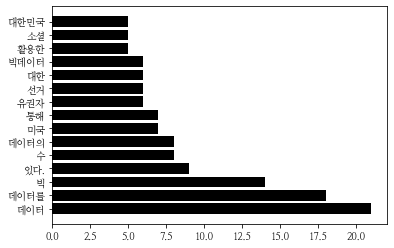

In [29]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumMyeongjo')
plt.barh(range(len(v)), v, color = 'black')
plt.yticks(range(len(v)), k)
plt.show()

'Nanum' 또는 'Myeongjo' 한글 폰트가 설치되었는지 확인하고, 그 중의 적당한 폰트를 사용하자.

In [30]:
from matplotlib import font_manager
for font in font_manager.fontManager.ttflist:
    if 'Myeongjo' in font.name:
        print(font.name, font.fname)

NanumMyeongjo C:\Users\user\AppData\Local\Microsoft\Windows\Fonts\NanumMyeongjo.ttf
NanumMyeongjo C:\Users\user\AppData\Local\Microsoft\Windows\Fonts\NanumMyeongjoExtraBold.ttf
NanumMyeongjo YetHangul C:\Users\user\AppData\Local\Microsoft\Windows\Fonts\NanumMyeongjo-YetHangul.ttf
NanumMyeongjo C:\Users\user\AppData\Local\Microsoft\Windows\Fonts\NanumMyeongjoBold.ttf
NanumMyeongjo Eco C:\Users\user\AppData\Local\Microsoft\Windows\Fonts\NanumMyeongjoEcoR.ttf
